# **Ocean and Land Temperature Anomalies**

### Description
The project aims to analyze global temperature change over time through data visualization techniques. It involves gathering temperature anomalies data from diverse sources, processing, and cleaning it before employing various visualization methods. The objective is to provide insights into climate change trends and patterns, fostering understanding and urgency for sustainable practices and environmental supervision.

---
### **Team Members**

*   Saffian Asghar
*   Alexis Culpin
*   Romaric Sallustre
*   Emilio Espinosa S.

---

In [318]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import urllib.request
from pathlib import Path
import json

### Constants and Functions

In [319]:
NOAA_URL = "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/1/12/1850-2023/data.json"
BERKLEY_URL = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Raw_TMAX_complete.txt"
HAD_CRUT5_URL = "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.csv"

#### Function to get data if it doesn't exist

In [320]:
def save_data(urls, folder):
    """
    Downloads data from the given URLs and saves it in the specified folder.

    Args:
        urls (dict): A dictionary containing the names and URLs of the data files to be downloaded.
        folder (str): The name of the folder where the data files will be saved.

    Returns:
        None
    """
    subfolder = Path(f"./data/{folder}")
    subfolder.mkdir(parents=True, exist_ok=True)
    
    for key, url in urls.items():
        website_url = url.split("/")[2]
        file_extension = url.split(".")[-1]
        filepath = subfolder / f"{key}.{file_extension}"
        
        if not filepath.exists():
            urllib.request.urlretrieve(url, filepath)
            print(f"Data saved for {website_url} at {filepath}")
        else:
            print(f"Data already exists for {website_url} at {filepath}")

### Fetching global temperature data

In [321]:
urls = {"noaa_df" : NOAA_URL, "berkley_df" : BERKLEY_URL, "had_crut5_df" : HAD_CRUT5_URL}
save_data(urls, "global_temperature")

Data already exists for www.ncei.noaa.gov at data\global_temperature\noaa_df.json
Data already exists for berkeley-earth-temperature.s3.us-west-1.amazonaws.com at data\global_temperature\berkley_df.txt
Data already exists for www.metoffice.gov.uk at data\global_temperature\had_crut5_df.csv


## Data Cleaning & Transformation


#### **NOAA dataset**

The dataset is hosted by NOAA's National Centers for Environmental Information (NCEI). It contains temperature anomaly data, representing deviations from a reference temperature over time. 

**Technical information**

* Data is collected from 1850 - 2023.
* The data is in JSON format.
* Columns of interest: year and data (yearly anomaly).

| Field        | Description                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| `DATE`  | Period of time in years.                                                                          |
| `DESCRIPTION`  | Description of data set itself.                                                                                       |
| `DATA`        | Anomaly in degrees Celsius.                                       |

**Data transformation required**
1. Read JSON.
2. Drop the description column.
3. Ensure every value within the date and data columns is numeric. The non-numeric values have to be drop.
4. Make sure the index (date) is an integer type value.
5. Rename data column to NOAAGlobalTemp and add the minimum and maximum years.

**Link**

* https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/1/12/1850-2023/data.json

**License**

Creative Commons Attribution 4.0 International license (CC-BY-4.0)


In [322]:
# Read Json file
df_noaa = pd.read_json("./data/global_temperature/noaa_df.json")

# Dataframe drop unnecessary columns and rows that are not numeric and set index as int
df_noaa = (
    df_noaa
    .drop('description', axis=1)
    .loc[pd.to_numeric(df_noaa.index, errors='coerce').notna()]
)
df_noaa.index = df_noaa.index.astype(int)
# Rename columns with specific format for better visualization
df_noaa = df_noaa.rename(columns=lambda x: f"NOAAGlobalTemp ({df_noaa.index.min()} - {df_noaa.index.max()})")
df_noaa.head()

,NOAAGlobalTemp (1850 - 2023)
1850,-0.06
1851,-0.08
1852,-0.01
1853,-0.12
1854,0.02


#### **CRUT5 dataset**

The dataset is derived from the Hadley Centre for Climate Science and Services at the UK Met Office, suggesting tabular data, possibly containing global monthly climate information. The dataset includes time series summaries for global climate analysis, incorporating columns with both upper and lower confidence limits.

**Technical information**

* Data collected from 1850 - 2023.
* The data is in CSV format.
* Columns of interest: year and anomaly in degrees celsius (temperature anomaly).

| Field        | Description                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| `YEAR_MONTH`  | Period of time in "YYYY-MM" format.                                                                      |
| `ANOMALY IN DEGREES CELSIUS`  | Monthly anomaly in degrees celsius.                                                                                   |
| `LOWER CONFIDENCE LIMIT (2.5%)`        | Numbers at the lower end of the confidence interval.                |
| `UPPER CONFIDENCE LIMIT (97.5%)`        | Numbers at the upper end of the confidence interval.                     |

**Data transformation required**
 1. Read a CSV file into a pandas DataFrame, parsing the 'Time' column as dates.
 2. Group the DataFrame by the year part of the 'Time' column.
 3. Calculate the mean of the 'Anomaly (deg C)' column for each year.
 4. Reset the DataFrame index.
 5. Set the 'Time' column as the new index.
 6. Convert the index values to integers.
 

**Link**

* https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.csv

**License**

Open Government License (OGL) for Public Sector Information.

In [323]:
# read second dataset
had_crut5_df = pd.read_csv('./data/global_temperature/had_crut5_df.csv', parse_dates=['Time'])
# Group by year and calculate average per year.
had_crut5_df = (
    had_crut5_df
    .groupby(had_crut5_df['Time'].dt.year)['Anomaly (deg C)'].mean().reset_index()
    .set_index('Time')
)
# Set index as int
had_crut5_df.index = had_crut5_df.index.astype(int)
had_crut5_df.head()

,Anomaly (deg C)
Time,
1850,-0.417711
1851,-0.233350
1852,-0.229399
1853,-0.270354
1854,-0.291521


#### **Berkley dataset**

The dataset is associated with the Berkeley Earth project, an independent climate science organization, the dataset focuses on the "Annual Anomaly" column. Housed on Amazon S3, the data contains raw maximum temperature (TMAX) data, reflecting the highest recorded temperatures.

**Technical information**

* Data collected from 1850 - 2023.
* The dataset has missing values in 2023.
* The data is in TXT format.
* Columns of interest: year and annual anomaly (difference of temperature from a base reference).

| Field        | Description                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| `YEAR`  | Period of time in years.                                                 |
| `MONTH`  | Period of time in months.                                                                          |
| `MONTHLY ANOMALY`        | Monthly anomaly in degrees celsius.                                     |
| `ANNUAL ANOMALY`        | Yearly anomaly in degrees celsius.               |
| `FIVE YEAR ANOMALY`        | 5 year rolling average anomaly in degrees celsius.               |
| `TEN YEAR ANOMALY`        | 10 year rolling average anomaly in degrees celsius.               |
| `TWENTY YEAR ANOMALY`        | 20 year rolling average anomaly in degrees celsius.           |

**Data transformation required**
 1. Read a space-delimited text file into a pandas DataFrame, ignoring lines that start with "%".
 2. Group the DataFrame by the 'year' column.
 3. Calculate the mean of the 'anomaly' column for each year.
 4. Reset the DataFrame index.
 5. Set the 'year' column as the new index.
 6. Convert the index values to integers.
 
**Link**

* https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Raw_TMAX_complete.txt

**License**

Creative Commons Attribution 4.0 International license (CC-BY-4.0)


In [324]:
# Read third dataset
berkley_df = pd.read_csv('./data/global_temperature/berkley_df.txt', comment="%", delim_whitespace=True, names= ["year", "month", "anomaly", "yearAvgAnomaly", "5yearAvgAnomaly", "10yearAvgAnomaly", "20yearAvgAnomaly"])
# Group by year and calculate average per year.
berkley_df = (
    berkley_df
    .groupby(berkley_df['year'])['anomaly'].mean().reset_index()
    .set_index('year')
)
berkley_df.index = berkley_df.index.astype(int)
berkley_df

C:\Users\baigs\AppData\Local\Temp\ipykernel_1340\1782113149.py:2: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



,anomaly
year,
1850,-1.141667
1851,-0.971583
1852,-1.007917
1853,-0.382333
1854,-0.170500
...,...
2019,1.199167
2020,1.391000
2021,1.160500


In [325]:
# Joining the dataframes and renaming the columns for the final merge below
merged_df = (
    df_noaa
    .join(had_crut5_df.rename(columns={'Anomaly (deg C)': 'HadCRUT5_Anomaly'}), how='left')
    .join(berkley_df.rename(columns={'anomaly':'Berkley_anomaly'}), how='left')
)

# Final merge with all three datasets
merged_df = (
    merged_df
    .rename(columns={'HadCRUT5_Anomaly': f"HAD_CRUT5 ({had_crut5_df.index.min()} - {had_crut5_df.index.max()})"})
    .rename(columns={'Berkley_anomaly': f"BerkleyEarth ({berkley_df.index.min()} - {berkley_df.index.max()})"})
)

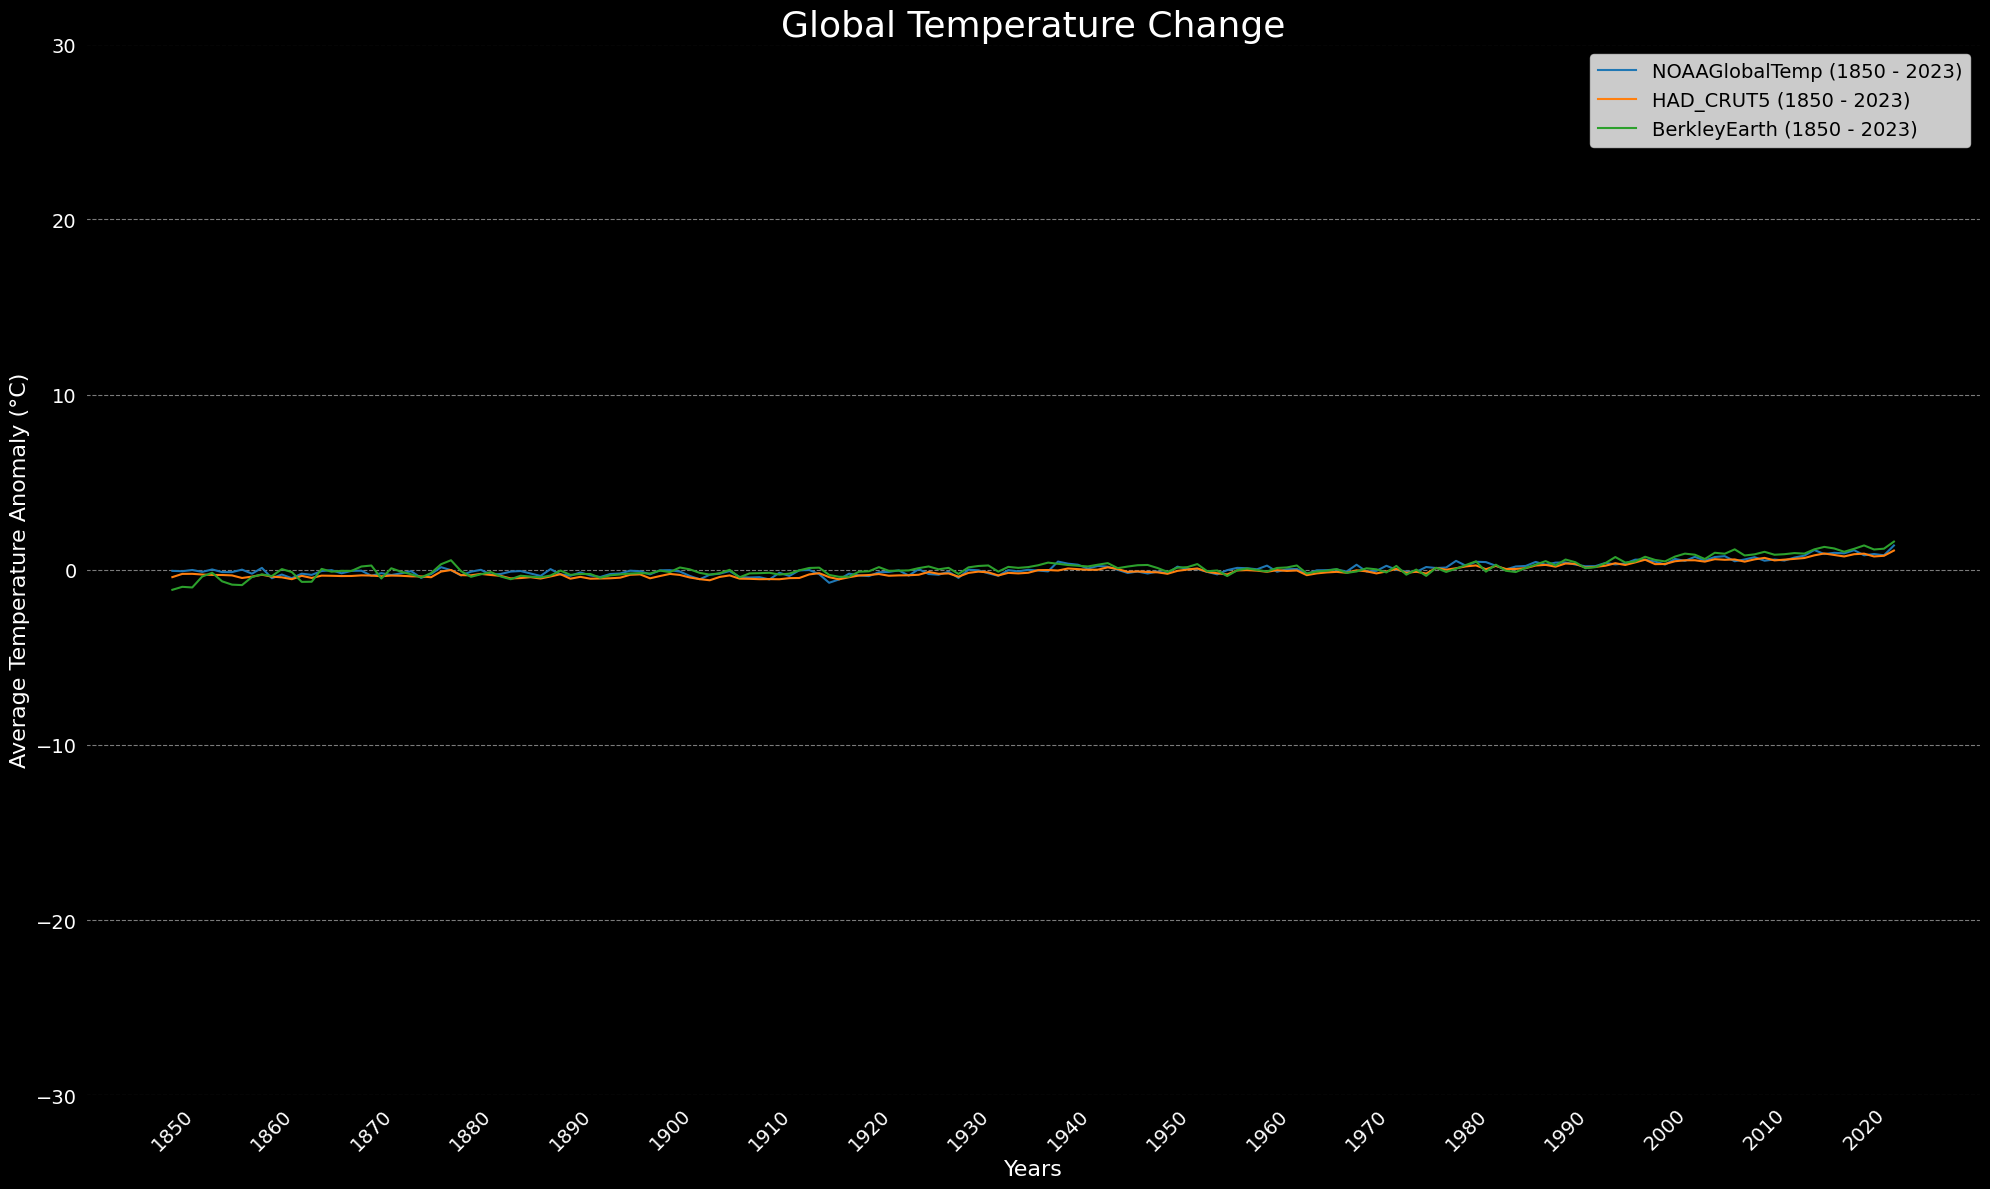

In [326]:
# Plot individual datasets
plt.figure(figsize=(20, 12), facecolor='black')
bars = plt.plot(merged_df.index, merged_df)

plt.title('Global Temperature Change', fontsize=26, color='white')
plt.xlabel('Years', fontsize=16, color='white')
plt.ylabel('Average Temperature Anomaly (°C)', fontsize=16, color='white')
plt.xticks(range(merged_df.index.min(), merged_df.index.max(), 10), rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().set_facecolor('black')

plt.legend(merged_df.columns, fontsize=14)
plt.ylim(-30, 30)
plt.tight_layout()
plt.show()

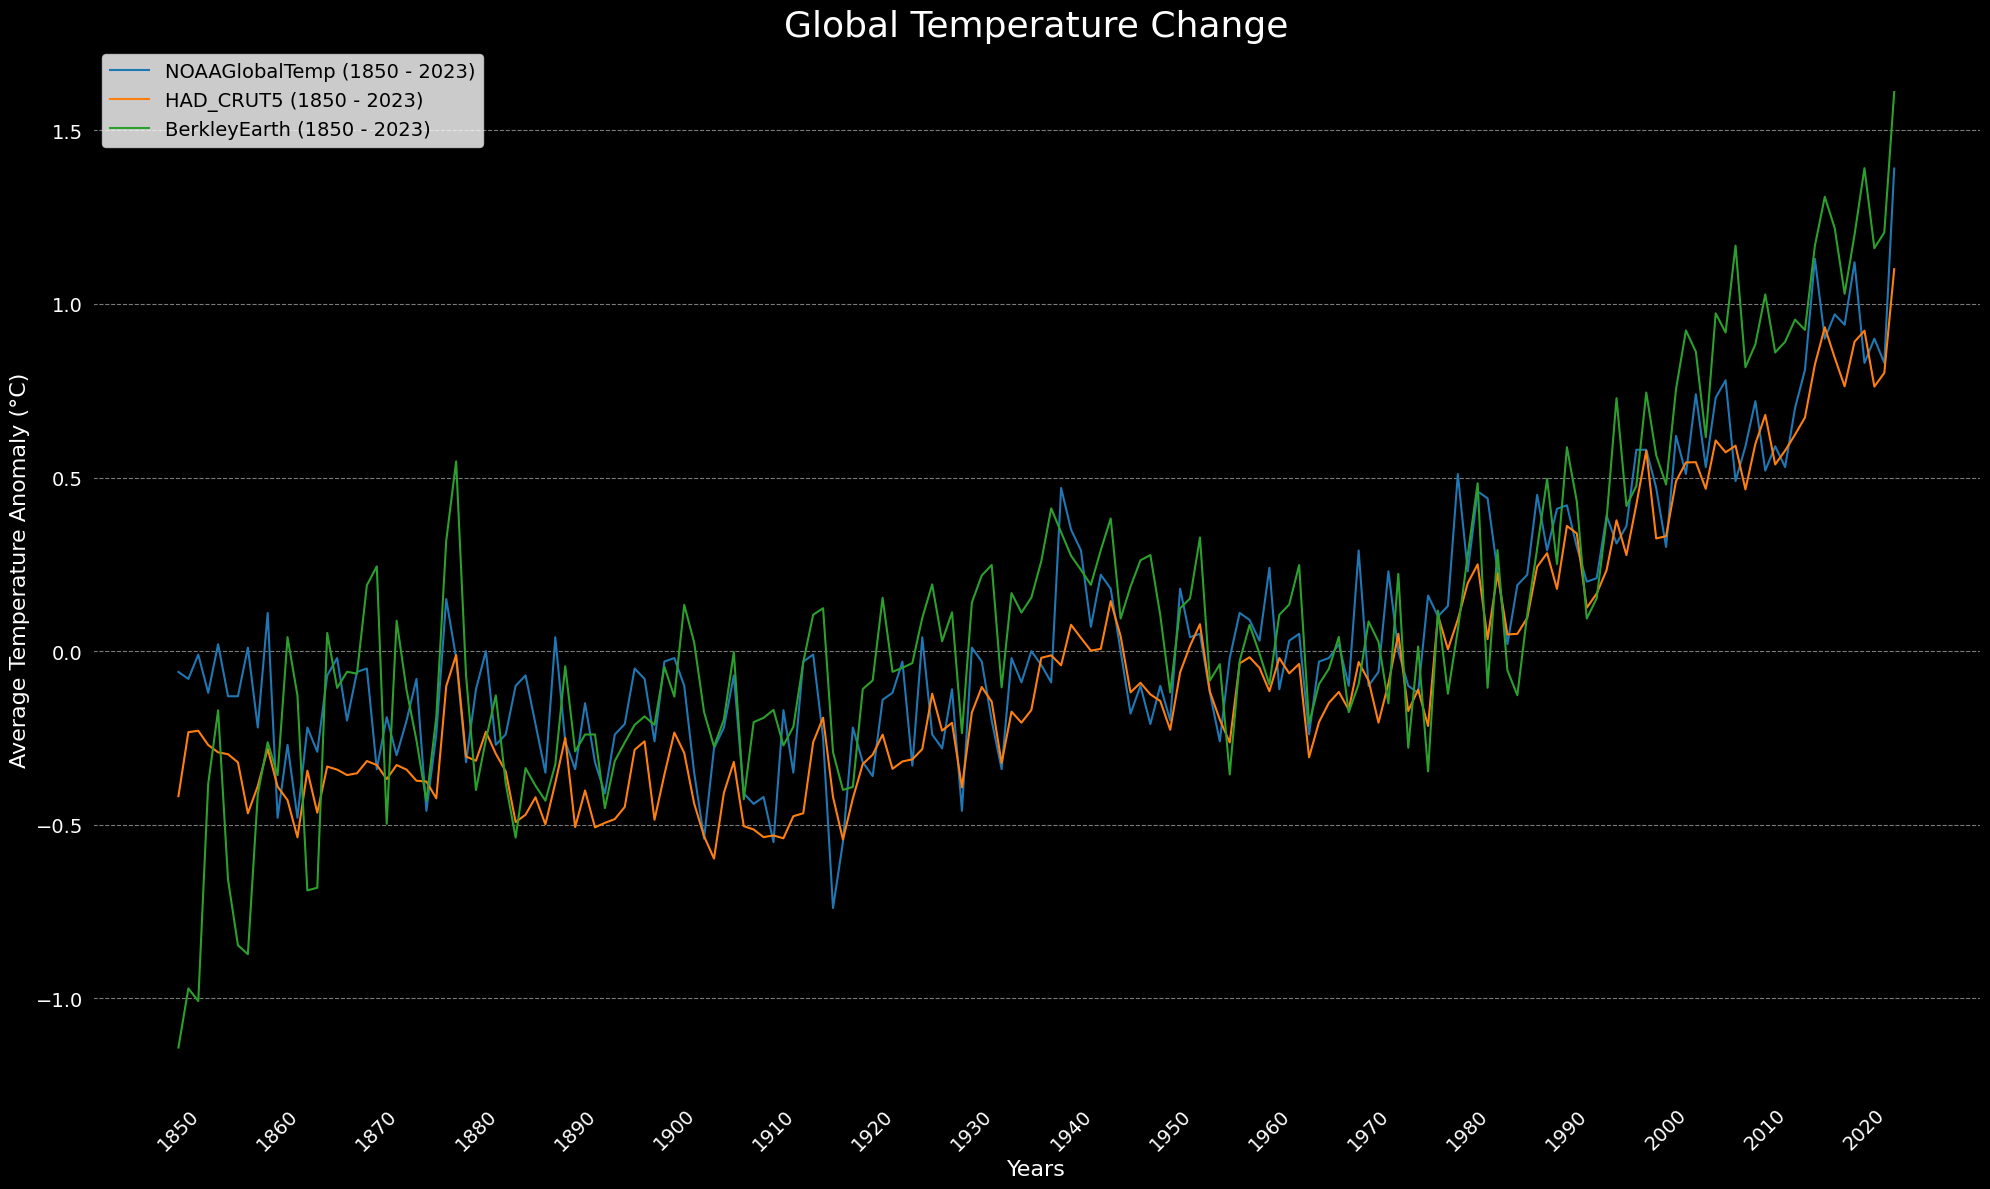

In [327]:
# Plot individual datasets
plt.figure(figsize=(20, 12), facecolor='black')
bars = plt.plot(merged_df.index, merged_df)

plt.title('Global Temperature Change', fontsize=26, color='white')
plt.xlabel('Years', fontsize=16, color='white')
plt.ylabel('Average Temperature Anomaly (°C)', fontsize=16, color='white')
plt.xticks(range(merged_df.index.min(), merged_df.index.max(), 10), rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().set_facecolor('black')

plt.legend(merged_df.columns,fontsize= 14)
plt.tight_layout()
plt.show()

In [328]:
merged_df['obs_average'] = merged_df[['NOAAGlobalTemp (1850 - 2023)','HAD_CRUT5 (1850 - 2023)','BerkleyEarth (1850 - 2023)']].mean(axis=1)

# Extract the decade from the year
merged_df['Decade'] = merged_df.index // 10 * 10

# This is performing an operation on the index of the DataFrame. 
# The // operator in Python performs floor division. This means it divides the number and then rounds down to the nearest whole number. 
# So, merged_df.index // 10 is dividing the index by 10 and rounding down. This effectively extracts the decade from a year. 
# For example, if the index was the year 1995, 1995 // 10 would give 199. Multiplying by 10 gets us back to the decade, 1990 in this case.

# Calculate the decadal averages
decadal_averages = merged_df.groupby('Decade')['obs_average'].mean()

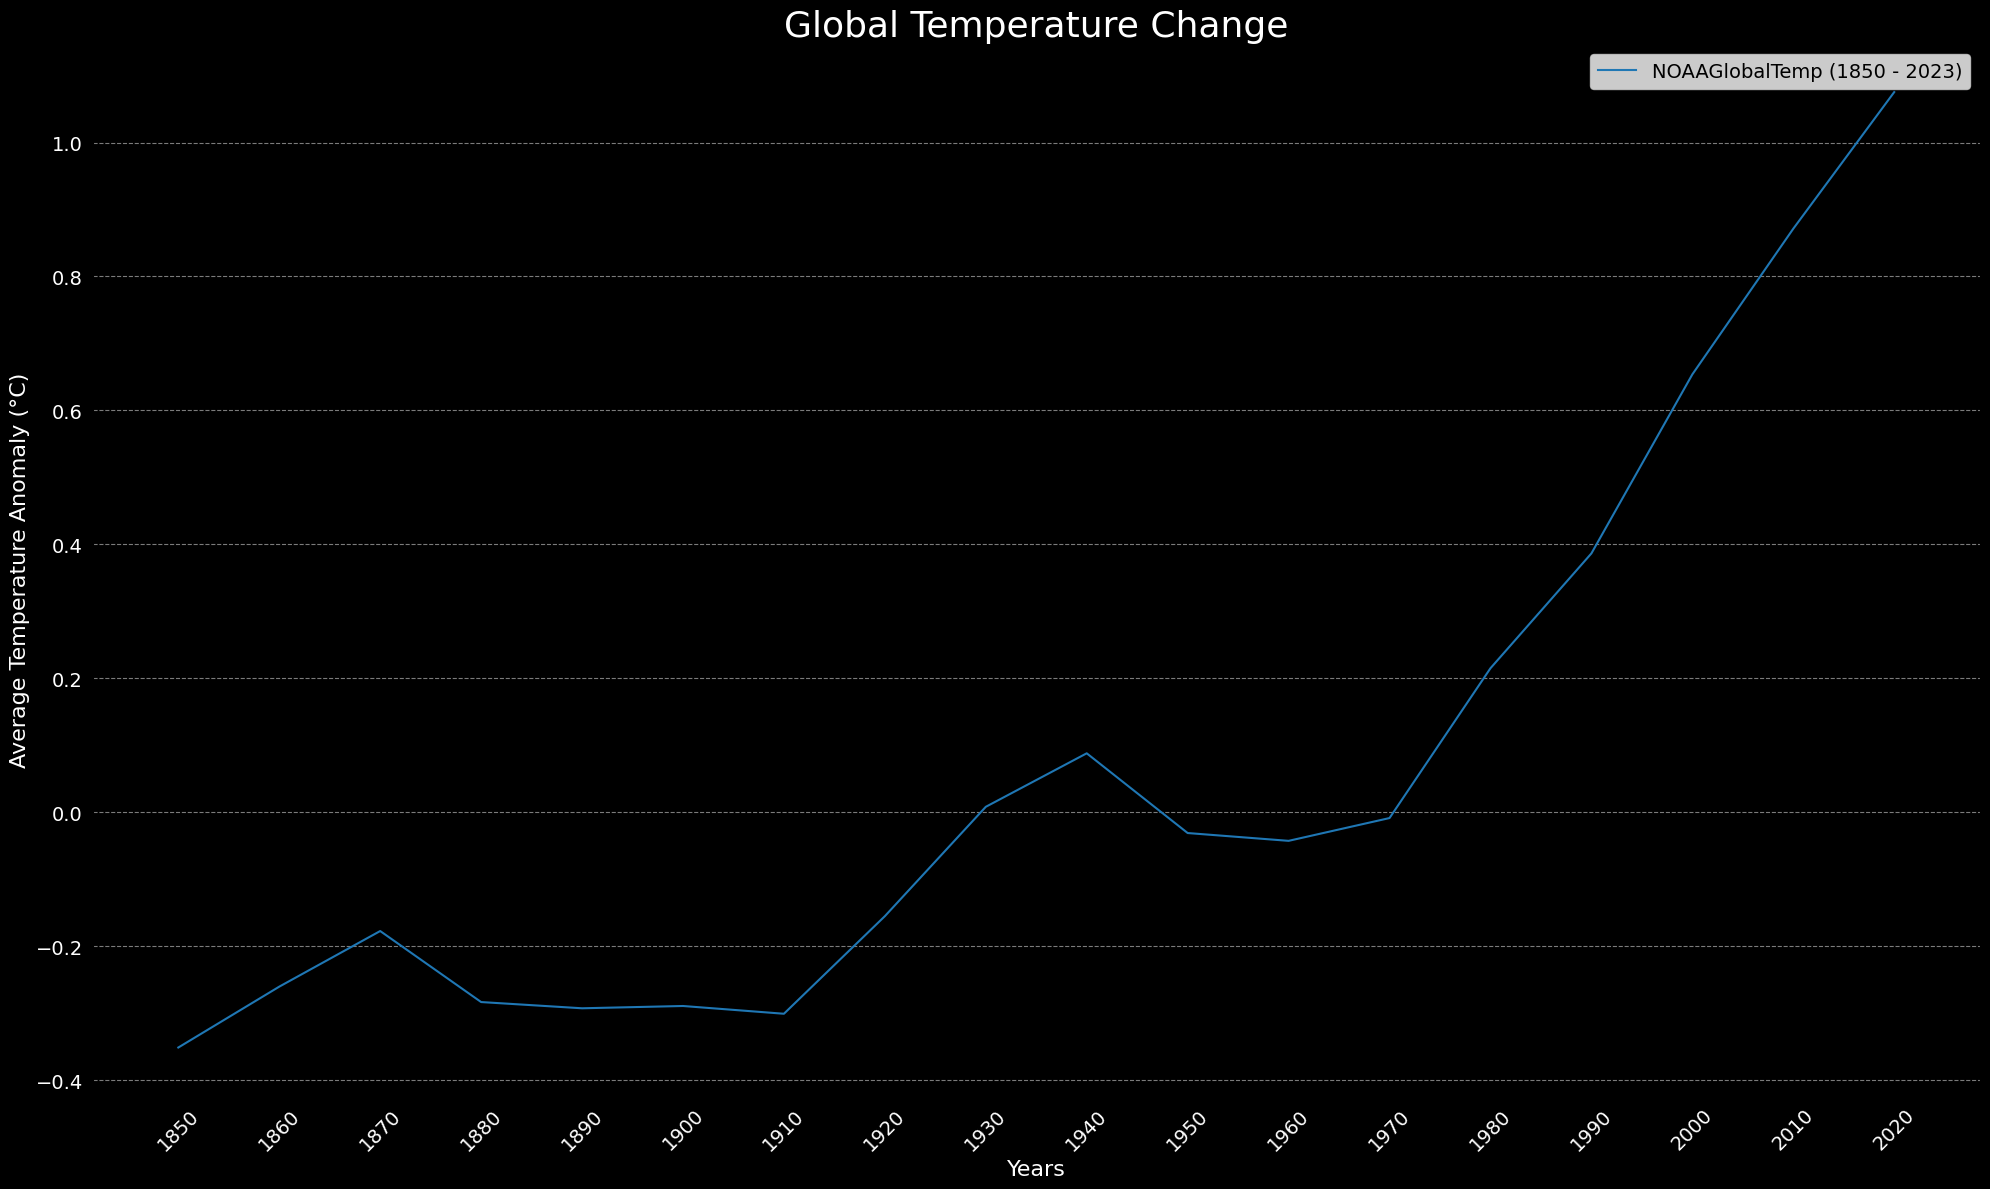

In [329]:
# Plot individual datasets
plt.figure(figsize=(20, 12), facecolor='black')
bars = plt.plot(decadal_averages.index, decadal_averages )

plt.title('Global Temperature Change', fontsize=26, color='white')
plt.xlabel('Years', fontsize=16, color='white')
plt.ylabel('Average Temperature Anomaly (°C)', fontsize=16, color='white')
plt.xticks(range(merged_df.index.min(), merged_df.index.max(), 10), rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().set_facecolor('black')
plt.legend(merged_df.columns, fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\baigs\AppData\Local\Temp\ipykernel_1340\2113613148.py:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



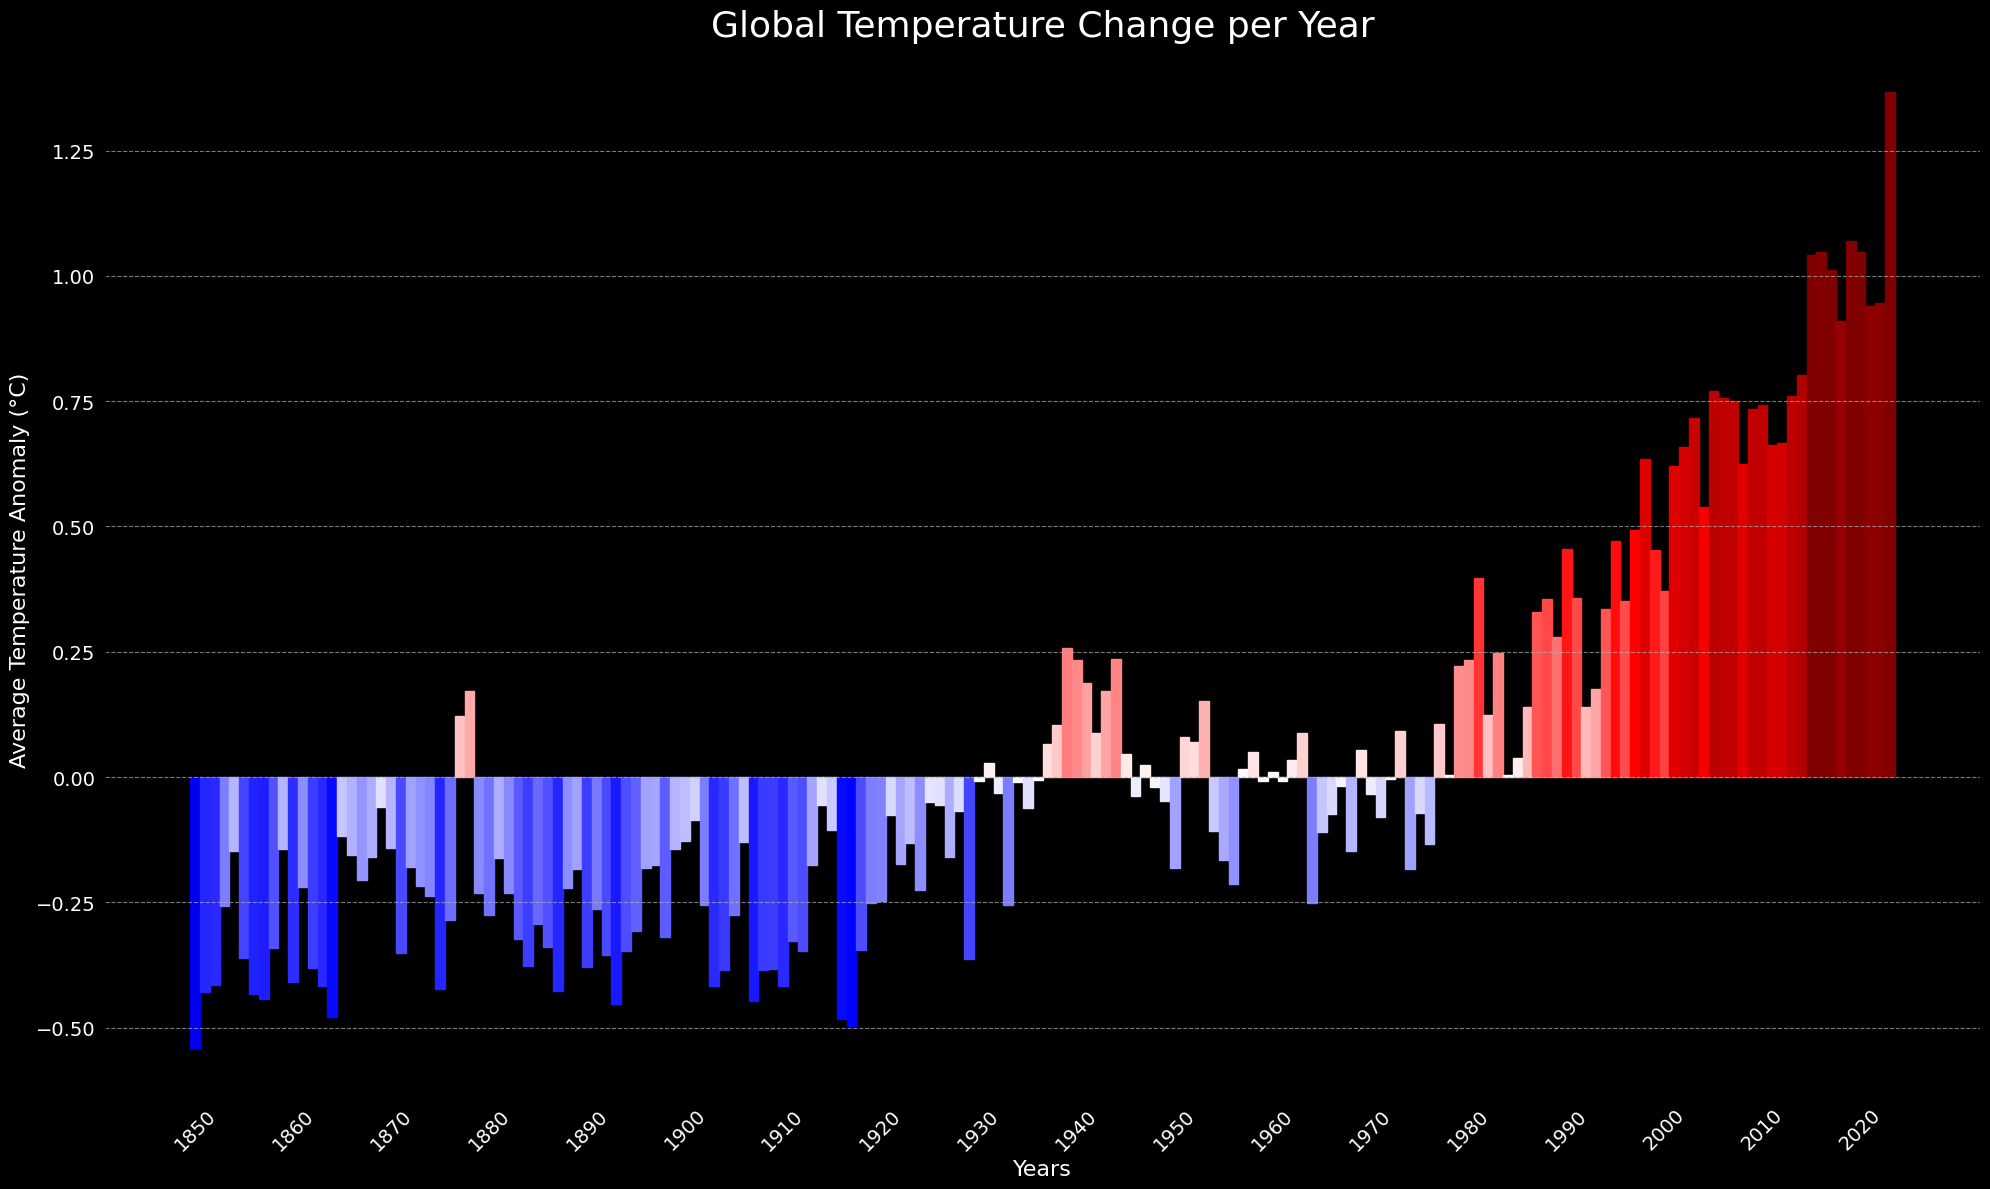

In [330]:
# Calculate the observatories averages
observatories_averages = merged_df[['NOAAGlobalTemp (1850 - 2023)','HAD_CRUT5 (1850 - 2023)','BerkleyEarth (1850 - 2023)']].mean(axis=1)

# Define the color map for the gradient
color_map = plt.cm.get_cmap('seismic')

# Plot decadal temperature anomalies with enhanced aesthetics
plt.figure(figsize=(20, 12), facecolor='black')
bars = plt.bar(merged_df.index, observatories_averages, edgecolor='gray', width=1)
# Set the color of each bar based on the y value
for bar, value in zip(bars, observatories_averages):
    color = color_map((value + 1) / 2)  # Normalize the value to range from 0 to 1
    bar.set_color(color)

plt.title('Global Temperature Change per Year', fontsize=26, color='white')
plt.xlabel('Years', fontsize=16, color='white')
plt.ylabel('Average Temperature Anomaly (°C)', fontsize=16, color='white')
plt.xticks(range(merged_df.index.min(), merged_df.index.max(), 10), rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().set_facecolor('black')

plt.tight_layout()
plt.show()

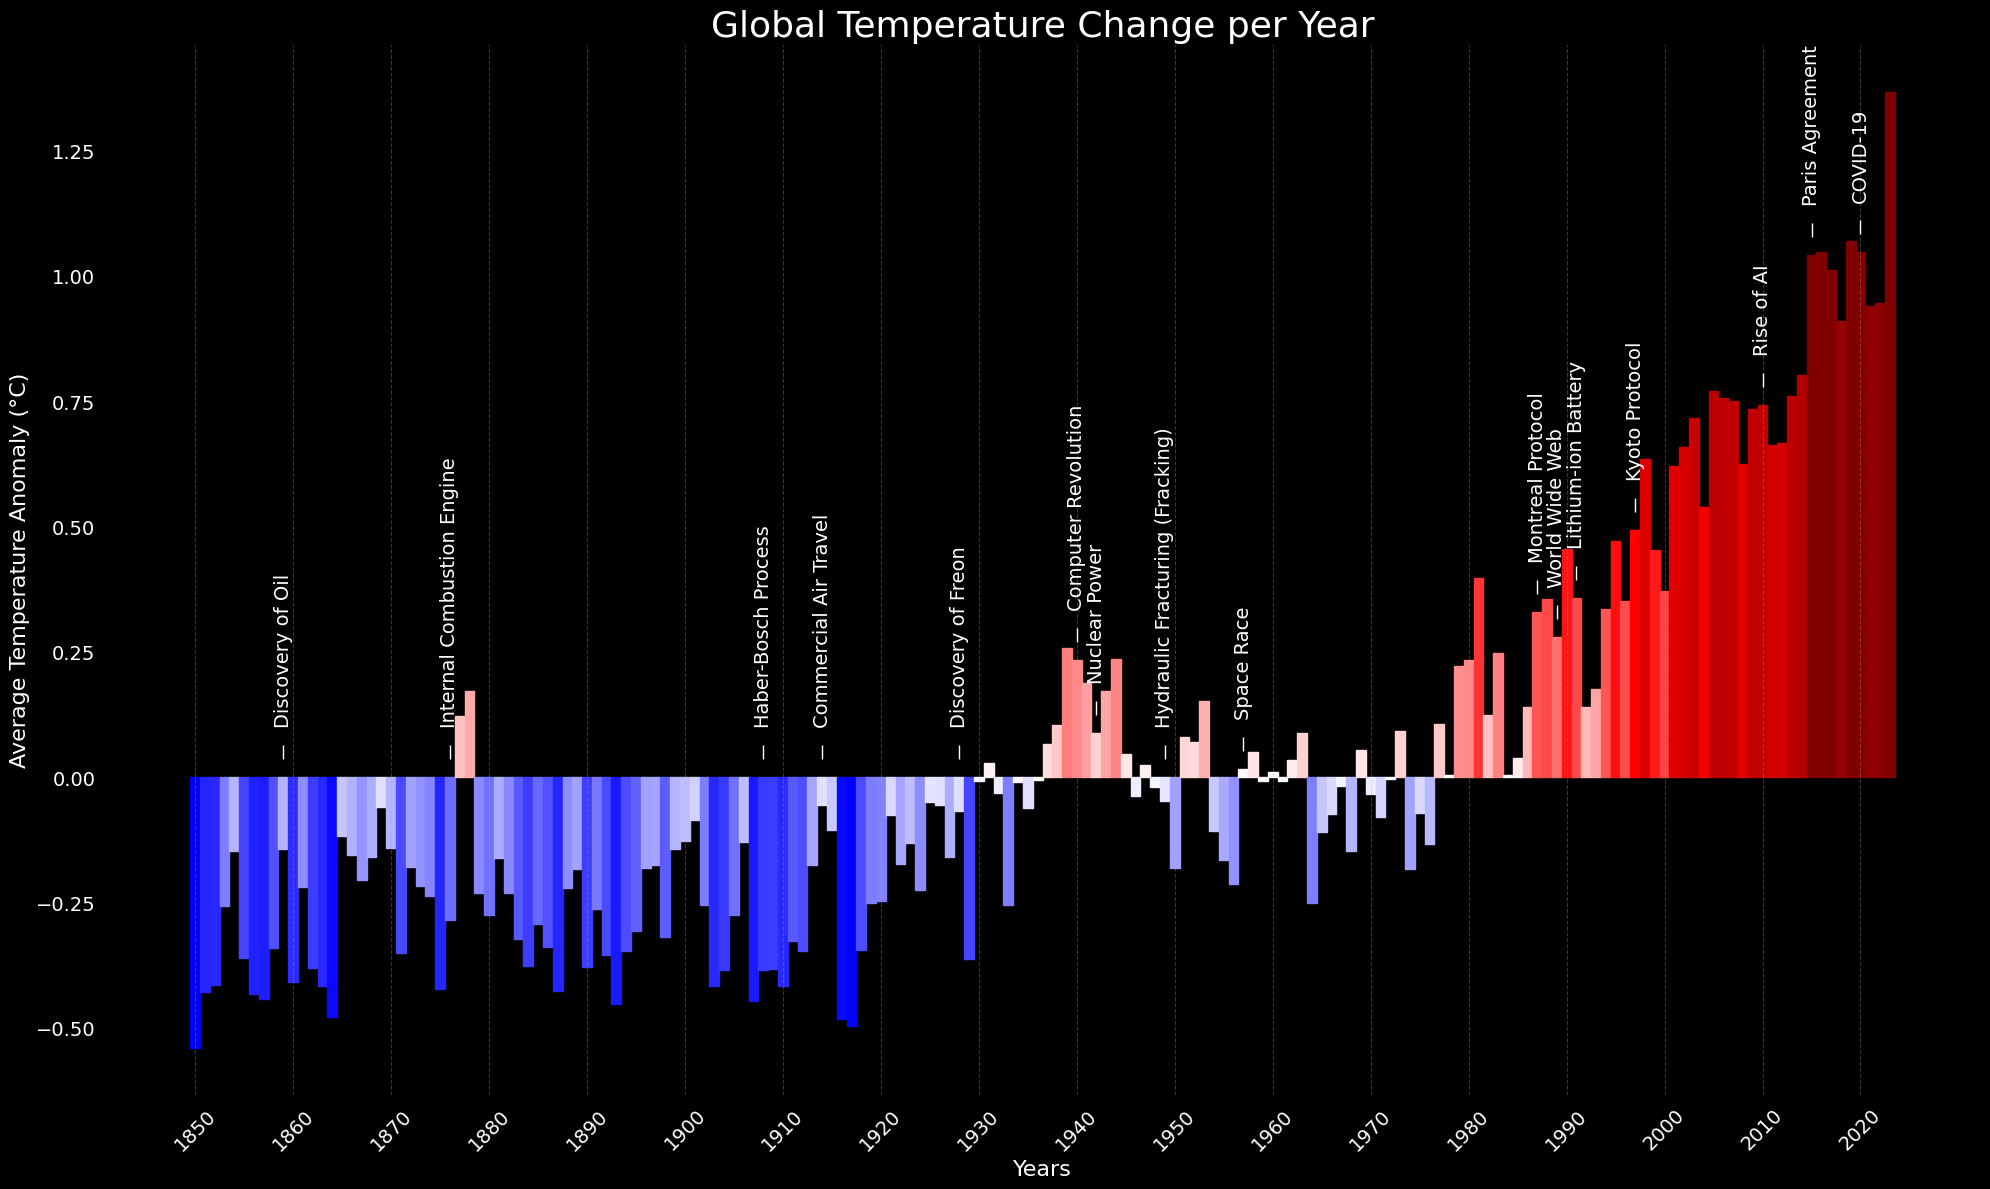

In [331]:
# Load the data from the JSON file
with open('Resources/major_events.json', 'r') as file:
    climate_data = json.load(file)

plt.figure(figsize=(20, 12), facecolor='black')
bars = plt.bar(merged_df.index, observatories_averages, edgecolor='gray', width=1)

# Set the color of each bar based on the y value
for bar, value in zip(bars, observatories_averages):
    color = color_map((value + 1) / 2)  # Normalize the value to range from 0 to 1
    bar.set_color(color)

# Add vertical lines for events
for event in climate_data:
    year = event["Year"]
    event_name = event["Invention/Event"]
    if year in merged_df.index:
        # Get the height of the corresponding bar if it is negative 
        if observatories_averages[year] < 0:
            bar_height = 0.05
        else:
            bar_height = observatories_averages[year] + 0.05
        # Plot the marker above the bar
        plt.plot(year, bar_height, marker='|', color='white', markersize=10)  # Add short vertical line
        plt.text(year, bar_height + 0.05, event_name, color='white', rotation=90, ha='center', va='bottom', fontsize=14)

plt.title('Global Temperature Change per Year', fontsize=26, color='white')
plt.xlabel('Years', fontsize=16, color='white')
plt.ylabel('Average Temperature Anomaly (°C)', fontsize=16, color='white')
plt.xticks(range(merged_df.index.min(), merged_df.index.max(), 10), rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.gca().set_facecolor('black')

plt.tight_layout()
plt.show()
